In [1]:
import numpy as np
from numba import njit, prange
import random
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
e = 1.6 * 10 ** (-19)
m_i = 2.18 * 10 ** (-25)
m_el = 9.1*10**(-31)
S = 4*10**(-5)
L = 5*10**(-3)
ds = 1.25*10**(-9)
r = (ds/np.pi)*(1/2)
sigma = np.pi * (1.08359075266265*10**(-10))**2
k_b = 1.38*10**(-23)
T = 1500
e0 = 8.85 * 10 ** (-12)

In [3]:
def get_n_i(I =20 * 10 ** (-3), e = e, u = 1200, S = S, m = m_i):
    return I / (e * S * ((2 * e * u) / m)**(1/2))

def get_cur_el(): # при равных концентрациях
    return get_n_i() * S * e * ((3 * k_b * T / m_el)**(1/2))

def get_n_el(I = get_cur_el()): #на вход подается ток электронов
    return I / (e * S * (3 * k_b * T / m_el) ** (1/2))

In [4]:
# концентрации
n_i = get_n_i()
conc_el = [get_n_el(), get_n_el(0.25), get_n_el(0.45)] #для трех экспериментов

# исследуемое количество частиц
num_of_el = []
num_of_i = []
m = []

In [5]:
v0_i = (2 * e *(1200)/(m_i))**(1/2)
v0_el = (3*k_b*T/(m_el))**(1/2)

In [6]:
dl_lambda = []
for n_el0 in conc_el:
    dl_lambda.append(((v0_i / (ds * get_n_i() * n_el0 * sigma * (v0_i + v0_el)*1000)))**(1/2))

#расчет числа отрезков dl для каждого тока и числа частиц в ds dl
for dl, nel in zip(dl_lambda, conc_el):
    m.append(int(L/dl))
    num_of_el.append(int(nel*ds*dl))
    num_of_i.append(int(n_i*ds*dl))

[2.326994845673955e-05, 1.6420420862756804e-05, 1.2239059089426654e-05]


In [7]:
#задаем точки со случайными координаты в трубке тока
@njit(fastmath=True)
def get_random_coords(l, r):
    z = random.uniform(0, l)
    x = random.uniform(-r, r)
    y = random.uniform(-r, r)

    while y > (r**2 - x**2)**(1/2) or -y > (r**2 - x**2)**(1/2):
        y = random.uniform(-r, r)
    return (x, y, z)

In [8]:
#вычисление процессов нейтрализации
@njit(fastmath=True)
def start_experiment(m, n_i, n_el, l, r):

    qtty_ions = [] #количество ионов после нейтрализации
    qtty_electrons = [] #количество электронов после нейтрализации
    qtty_neitrals = [] #количество нейтралов после нейтрализации
    ions = [] #ионы перед нейтрализацией
    electrons = [] #электроны перед нейтрализацией
    neitrals = [] #нейтралы

    section_radius = 1.08359075266265*10**(-10)

    #counter = 1 #счетчик итераций

    for _ in prange(m): #повтор вычислений столько раз, сколько элекментов dl в трубке тока
        for _ in prange(n_i - len(neitrals)):
            ions.append(get_random_coords(l, r)) #генерируем координаты ионов (на каждой итерации случайные, чтобы учесть хаотические движения в плазме)

        for _ in prange(n_el - len(neitrals)):
            electrons.append(get_random_coords(l, r)) #генерируем координаты электронов

        for ion in ions: #для каждого иона проверяем каждый электрон
            for electron in electrons:
                if ((electron[0] - ion[0]) ** 2 + (electron[1] - ion[1]) ** 2 + (electron[2] - ion[2]) ** 2) ** (
                        1 / 2) <= section_radius: #сравнение разницы между радиус векторами иона и электрона с радиусом сечения аннигиляции
                    neitrals.append(ion) #при выполнении условия добавляем ион в нейтрали
                    electrons.remove(electron) # удаляем провазимодействовавшие электрон и ион
                    ions.remove(ion)
                    break
        qtty_neitrals.append(len(neitrals))  #на каждой итерации в массивы, регистрирующие количества частиц, вносим числа ионов, электронов и нейтралов
        qtty_electrons.append(len(electrons))
        qtty_ions.append(len(ions))

        #визуализация для контроля процесса
        #print(f'Итерация:{counter}', len(neitrals), len(electrons), len(ions), len(neitrals)/n_i * 100)
        #counter += 1

        #после проверки всех частиц очищаем массивы и переходим к следующей итерации
        ions.clear()
        electrons.clear()

    return (qtty_neitrals, qtty_electrons, qtty_ions) #на выходе получаем массивы с количеством электронов, ионов и нейтралов на каждой итерации

In [9]:
# расчет потенциала
def calc_pot(data_electrons, data_ions, dl, x_pot): #на вход подаем массивы с колличеством электронов и ионов в каждом элементе dl и массив значений х в мм

    delta_n = [] #разница между количеством ионов и электронов в каждом элементе
    for els, ins in zip(data_electrons, data_ions):
        delta_n.append((els - ins))

    #расстановка знаков в формлах соответсвует случаям, в которых количество электронов больше, чем ионов
    p0 = 1.6 * 10 ** (-19) * (data_electrons[0] - data_ions[0]) / e0 * dl #потенциал некомпенсированного заряда на входе в область
    potencials_x0 = [p0]

    #расчет потенциала некомппенсированного заряда
    for x, del_n in zip(x_pot, delta_n): # x в мм используется в качестве индекса
        potencials_x0.append(potencials_x0[int(x*10)] + e / e0 * del_n * dl)

    #расчет суммарного потенциала
    super_pot = []
    for x, pot in zip(x_pot, potencials_x0):
        super_pot.append((40000*x/1000-200) - pot) #40*x-200 - линейный потенциал

    return super_pot

In [10]:
#расчет скоростей в км/с
def calc_v_el(x_51, super_pot): #на вход подается массив х в мм и массив потенциалов с учетом потенциала заряда
    v = []
    v_0 = (3 * k_b * T / m_el) ** (1 / 2) #начальная скорость электрона
    for x, pot in zip(x_51, reversed(super_pot)):
        v.append((v_0 + (2 * e * abs(pot) / (m_el)) ** (1 / 2)) / 1000)
    return v

def calc_v_i(x_51, super_pot):
    v = []
    for x, pot in zip(x_51, super_pot):
        v.append((2 * e * (1000 - pot) / m_i) ** (1 / 2) / 1000)
    return v

#расчет длины пробега в мм
def calc_lambda(data_ions, data_electrons, V_i, V_el, dl):##на вход подается массивы с количествами электронов и ионов, их скоростей
    lambdas = []
    for n_i, n_el, v_i, v_el in zip(data_ions, data_electrons, V_i, V_el):
        if  n_i != 0: #проверка на случай полной нейтрализации
            lambdas.append((v_i / (ds * dl * n_i * n_el / (ds*ds*dl*dl) * sigma * (v_i + v_el))) * 1000) #с учетом перевода количества частиц в концентрации
        else:
            lambdas.append(0)
    return lambdas

#расчет потоков
def calc_flow(data_neitrals, V_i, V_el, dl):
    flow = []
    for N_neit, v_i, v_el in zip(data_neitrals, V_i, V_el):
        flow.append(e * N_neit * (-v_i - v_el)/(1000 * ds * dl))
    return flow

In [11]:
#старт эксперимента
experiments_data = []
#проводим три эксперимента для разных токов
for nel, ni, m0, dl in zip(num_of_el, num_of_i, m, dl_lambda):
    experiments_data.append(start_experiment(m0, ni, nel, dl, r))

k=0.39953810623556574
k=0.7414921465968586
k=0.9719051799824407


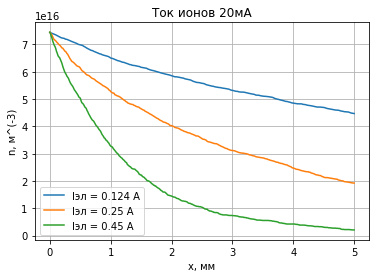

In [12]:
for data, N_el, N_i, m0, dl in zip(experiments_data, num_of_el, num_of_i, m, dl_lambda):
    x_51 = np.linspace(0, 5, m0+1)
    y_n = [N_i / (ds * dl)]
    data_neitrals = data[0]

    for y0 in data_neitrals:
        y_n.append((N_i - y0) / (ds * dl))
    print(f'k={1 -y_n[m0]/y_n[0]}')
    plt.plot(x_51, y_n, label=f'Iэл = {round((N_el * e * S * (3 * k_b*T/m_el)**(1/2))/(ds * dl), 3)} A')
    plt.xlabel('x, мм')
    plt.ylabel('n, м^(-3)')
    plt.title('Ток ионов 20мА')
plt.legend(loc='lower left')
plt.grid()
plt.show()

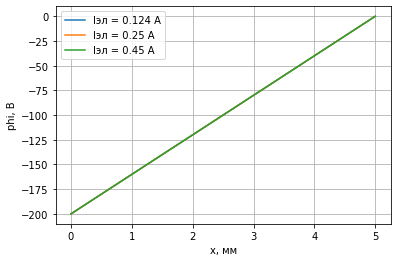

In [13]:
for data, N_el, m0, dl in zip(experiments_data, num_of_el, m, dl_lambda):
    data_electrons = data[1]
    data_ions = data[2]
    x_51 = np.linspace(0, 5, m0+1)
    plt.plot(x_51, calc_pot(data_electrons, data_ions, dl, x_51), label=f'Iэл = {round((N_el * e * S * (3 * k_b*T/m_el)**(1/2))/(ds * dl), 3)} A')
    plt.xlabel('x, мм')
    plt.ylabel('phi, В')
plt.legend()
plt.grid()
plt.show()

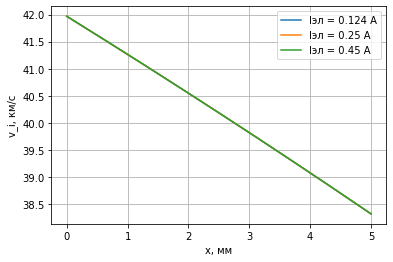

In [14]:
for m0, N_el, dl, data in zip(m, num_of_el, dl_lambda, experiments_data):
    data_electrons = data[1]
    data_ions = data[2]
    x_51 = np.linspace(0, 5, m0 + 1)
    plt.plot(x_51, calc_v_i(x_51, calc_pot(data_electrons, data_ions, dl, x_51)), label=f'Iэл = {round((N_el * e * S * (3 * k_b*T/m_el)**(1/2))/(ds * dl), 3)} A')
    plt.xlabel('x, мм')
    plt.ylabel('v_i, км/с')
plt.legend()
plt.grid()
plt.show()

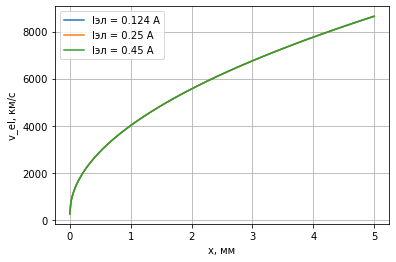

In [15]:
for m0, N_el, dl, data in zip(m, num_of_el, dl_lambda, experiments_data):
    data_electrons = data[1]
    data_ions = data[2]
    x_51 = np.linspace(0, 5, m0 + 1)
    plt.plot(x_51, calc_v_el(x_51, calc_pot(data_electrons, data_ions, dl, x_51)), label=f'Iэл = {round((N_el * e * S * (3 * k_b*T/m_el)**(1/2))/(ds * dl), 3)} A')
    plt.xlabel('x, мм')
    plt.ylabel('v_el, км/с')
plt.legend()
plt.grid()
plt.show()

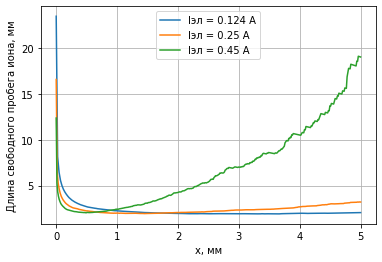

In [16]:
for data, N_el, m0, dl in zip(experiments_data, num_of_el, m, dl_lambda):
    x_51 = np.linspace(0, 5, m0 + 1)
    x_50 = np.linspace(0, 5, m0)
    data_ions = data[2]
    data_electrons = data[1]
    V_i = calc_v_i(x_51, calc_pot(data_electrons, data_ions, dl, x_51))
    V_el = calc_v_el(x_51, calc_pot(data_electrons, data_ions, dl, x_51))
    plt.plot(x_50, calc_lambda(data_ions, data_electrons, V_i, V_el, dl), label=f'Iэл = {round((N_el * e * S * (3 * k_b*T/m_el)**(1/2))/(ds * dl), 3)} A')
    plt.xlabel('x, мм')
    plt.ylabel('Длина свободного пробега иона, мм')
plt.legend()
plt.grid()
plt.show()

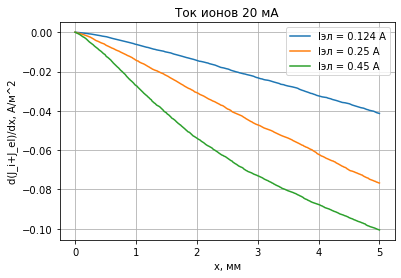

In [17]:
for data, N_el, N_i, m0, dl in zip(experiments_data, num_of_el, num_of_i, m, dl_lambda):
    x_51 =np.linspace(0, 5, m0)
    data_neitrals = data[0]
    data_electrons = data[1]
    data_ions = data[2]
    plt.plot(x_51, calc_flow(data_neitrals, calc_v_i(x_51, calc_pot(data_electrons, data_ions, dl, x_51)), calc_v_el(x_51, calc_pot(data_electrons, data_ions, dl, x_51)), dl), label=f'Iэл = {round((N_el * e * S * (3 * k_b*T/m_el)**(1/2))/(ds * dl), 3)} A')
    plt.xlabel('x, мм')
    plt.ylabel('d(J_i+J_el)/dx, А/м^2')
    plt.title('Ток ионов 20 мА')
plt.grid()
plt.legend()
plt.show()